# ML para predecir el gesto

Creación y evaluación de modelos de Machine Learning para predecir qué gesto está realizando el paciente

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,ArmsTogetherAngle_standardDeviation,ArmsTogetherAngle_Maximum,ArmsTogetherAngle_Minimum,ArmsTogetherAngle_Mean,ArmsTogetherAngle_Median,...,WristAngleRight_standardDeviation,WristAngleRight_Maximum,WristAngleRight_Minimum,WristAngleRight_Mean,WristAngleRight_Median,KneeAngleRight_standardDeviation,KneeAngleRight_Maximum,KneeAngleRight_Minimum,KneeAngleRight_Mean,KneeAngleRight_Median
0,101,0,1,1,stand,10.670341993092354,48.059652761639576,0.0048807662354137,21.234671517209446,22.83289147945006,...,27.747671544455784,179.99004458952922,1.895342254750395,158.3796393196956,167.5754479867348,33.21825901846228,179.96934757003004,23.627158746328853,152.77402908958072,168.526653468215
1,102,0,10,1,chair,12.916413412177558,165.07646943448404,1.289325958760638,23.98376953134508,22.54033601481008,...,31.99572402744675,179.93282577999278,0.3364676201884472,157.58054518853646,169.24449943332698,48.365156564099046,179.92348822231432,0.1283422443610501,141.18107432174696,173.60922079773533
2,102,0,11,1,chair,7.013930067617385,49.24618070566771,0.1209929594195576,21.95525314293939,22.401926795979254,...,33.27563948143619,179.98243741516615,0.1774984781081361,156.6778786388648,169.34187787891832,50.52797943663096,179.95026227783754,0.0635814082810828,142.12820195704057,174.23312184258162
3,102,0,12,1,chair,5.000322644745113,33.28243506266367,1.897672146230762,20.78844720302887,21.778025232022262,...,38.65090118051891,179.9385717238046,0.8063643067463825,151.63843805754541,167.54069579313867,53.012206560302246,179.97589943679105,0.0102929998186067,147.72526433711266,175.24697173885224
4,201,0,13,2,wheelchair,9.603500790057916,39.12405897390368,0.5542027645228198,13.140236375900592,9.921171176844595,...,38.45315891548698,179.98166657027105,4.256657550066159,152.5031049688768,170.6214059295001,83.00999004563369,179.75752719635332,0.0516894372294613,120.57424546783201,178.20503193476813


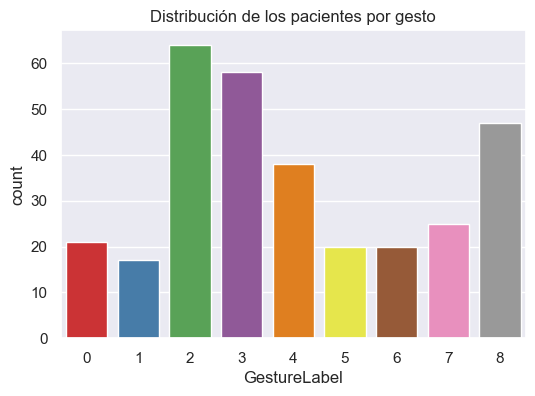

In [3]:
#---------Distribución de las clases--------
plt.figure(figsize=(6,4))

sns.countplot(x="GestureLabel", data=df, palette = "Set1")
plt.title("Distribución de los pacientes por gesto")
plt.show()

## 1. Preprocesado

### 1.1 Codificar variables

In [4]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [5]:
# Dividimos en train y test
df_train, df_test = train_test_split(df, test_size = 0.3, stratify=df['GestureLabel'])

# Dividimos el conjunto de train en varibales independientes y en target
train_X = df_train.drop(['GestureLabel'], axis = 1)
train_y = pd.DataFrame(df_train['GestureLabel'])

# Dividimos el conjunto de test
test_X = df_test.drop(['GestureLabel'], axis = 1)
test_y = pd.DataFrame(df_test['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()


## 2. Modelos de ML
Se ha creado una función para entrenar y evaluar los modelos

In [6]:
#-------Funcion para entrenar los modelos-----------
def aplicar_modelos(modelos: list, X:pd.DataFrame, y:pd.DataFrame, tX:pd.DataFrame, ty:pd.DataFrame):
   """
   Aplica una lista de modelos de aprendizaje automático a los datos de prueba y muestra
   los informes de evaluación.

   Parámetros:
   modelos (list): Lista de modelos de aprendizaje automático a evaluar.
   * X: datos de entrenamiento.
   * y: target de entrenamiento.
   * tX: datos de prueba.
   * ty: target de prueba.
   """
   # Iteramos sobre los modelos
   for modelo in modelos:
      modelo.fit(X,y) # entrenamos el modelo
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 

In [7]:
# creación de los modelos
knn = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

models = [knn, dtree, nb, svm, rf, lr]

# entrenamiento + evaluación
aplicar_modelos(models, train_X, train_y, test_X, test_y)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.80      0.80      0.80         5
           2       0.90      1.00      0.95        19
           3       0.94      1.00      0.97        17
           4       0.92      0.92      0.92        12
           5       1.00      0.67      0.80         6
           6       0.80      0.67      0.73         6
           7       0.57      0.50      0.53         8
           8       0.69      0.64      0.67        14

    accuracy                           0.83        93
   macro avg       0.81      0.78      0.79        93
weighted avg       0.83      0.83      0.82        93


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.75      0.60      0.67         5
           2       0.95      0.95      0.95        19
           3    

* Confusion matrix: cuanto más valores en la diagonal mejor
* Precision: cuanto más alta mejor
* Recall: cuanto más alta mejor
* F1-measure o F-score: cuanto más alta mejor
* Accuracy: cuanto más alta mejor

En la mayoría de ejecutiones los mejores son **DecisionTreeClassifier**, **KNeighborsClassifier** o **Regresión logistica**

In [8]:
#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX, ty):
    """
    Grafica la matriz de confusión para un modelo dado.

    Parámetros:
    * modelo: El modelo de clasificación entrenado.
    * tX: Los datos de prueba.
    * ty: Los valores reales del target para los datos de prueba.
    """
    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title('Confusion Matrix ' + modelo.__class__.__name__)
    plt.show()


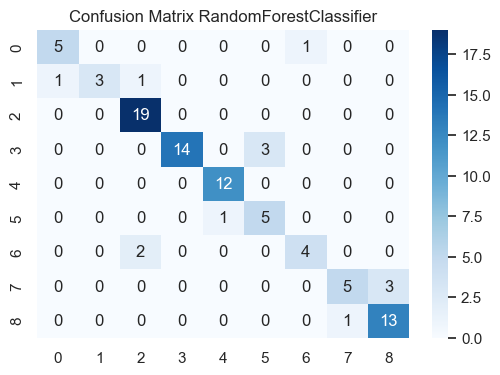

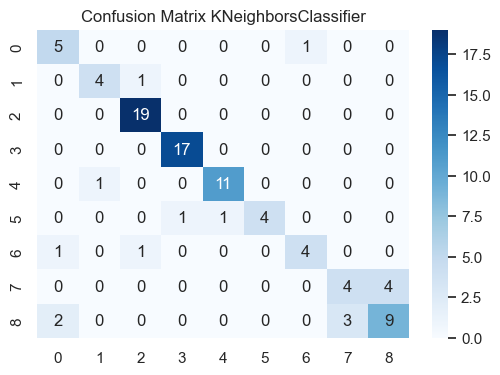

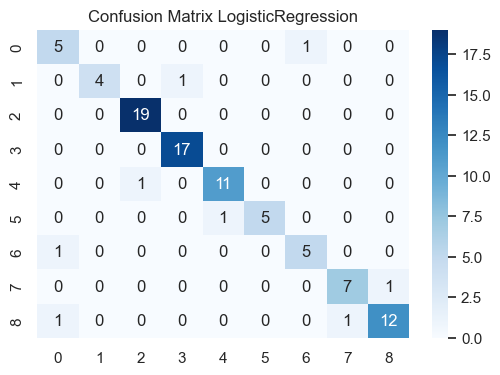

In [9]:
# Confusion Matrix para mejores modelos
plot_confusion_matrix(rf, test_X, test_y)
plot_confusion_matrix(knn, test_X, test_y)
plot_confusion_matrix(lr, test_X, test_y)

## 3. Hipermetrización

In [10]:
#-------------Parametros---------------
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [5, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [11]:
# GridSearchCV instances
gs_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
gs_dtree = GridSearchCV(dtree, param_grid_dtree, cv=5, scoring='accuracy')
gs_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='accuracy')
gs_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
gs_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
gs_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy') # !!!!!
# El parámetro cv=5 en GridSearchCV especifica una validación cruzada
# de 5 particiones (5-fold cross-validation)


In [12]:
def aplicar_hiperparametrizacion(modelos: list, X, y):
    for modelo in modelos:
        modelo.fit(X, y)
        print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
        # print(modelo.cv_results_) 
        print("Best parameters: ", modelo.best_params_)
        print("Best score: ", modelo.best_score_)

In [13]:
modelos_gs = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]

aplicar_hiperparametrizacion(modelos_gs, train_X, train_y)


Modelo: KNeighborsClassifier
Best parameters:  {'n_neighbors': 1}
Best score:  0.8986257928118393

Modelo: DecisionTreeClassifier
Best parameters:  {'criterion': 'gini', 'max_depth': 40}
Best score:  0.8430232558139534

Modelo: GaussianNB
Best parameters:  {'var_smoothing': 0.0012328467394420659}
Best score:  0.8894291754756871

Modelo: SVC
Best parameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Best score:  0.9307610993657505

Modelo: RandomForestClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 10}
Best score:  0.9493657505285412


In [14]:
def test_hiperparametrizacion(modelos, tX, ty):
       for modelo in modelos:
            best_modelo = modelo.best_estimator_ 
            prediction = best_modelo.predict(tX) #  predicciones en los datos de prueba
            report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
            print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
            print(report) 

test_hiperparametrizacion(modelos_gs, test_X, test_y)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.80      0.80      0.80         5
           2       0.90      1.00      0.95        19
           3       0.94      1.00      0.97        17
           4       0.92      0.92      0.92        12
           5       1.00      0.67      0.80         6
           6       0.80      0.67      0.73         6
           7       0.57      0.50      0.53         8
           8       0.69      0.64      0.67        14

    accuracy                           0.83        93
   macro avg       0.81      0.78      0.79        93
weighted avg       0.83      0.83      0.82        93


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.75      0.60      0.67         5
           2       1.00      1.00      1.00        19
           3    

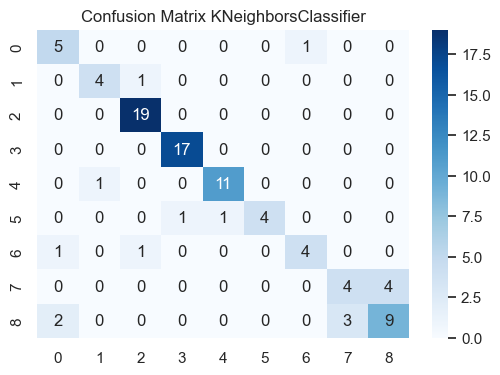

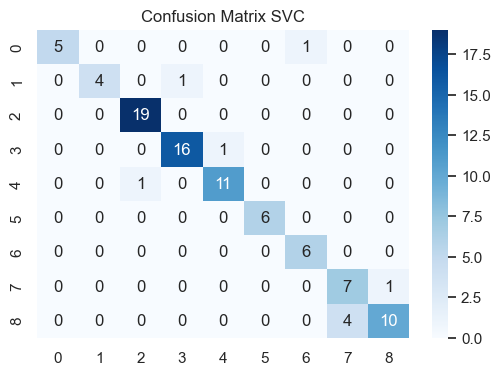

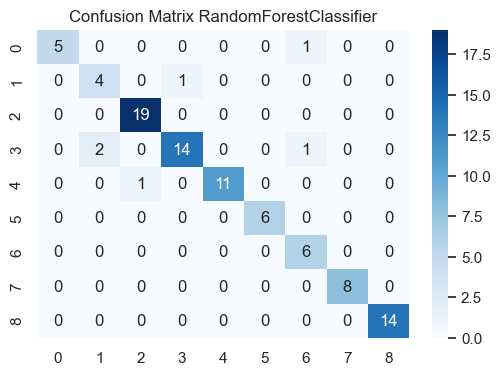

In [15]:
# Confusion Matrix para mejores modelos
plot_confusion_matrix(gs_knn.best_estimator_ , test_X, test_y)
plot_confusion_matrix(gs_svm.best_estimator_ , test_X, test_y)
plot_confusion_matrix(gs_rf.best_estimator_ , test_X, test_y)


In [16]:
df_X = df.drop(['GestureLabel'], axis = 1)
df_copy = df.copy()
df_copy['Prediction'] = gs_svm.predict(df_X)

# Insertar las nuevas columnas en las posiciones deseadas
df_copy.insert(2, 'Prediction', df_copy.pop('Prediction')) 

# Ordenar el DataFrame
df_copy['RepetitionNumber'] = df_copy['RepetitionNumber'].astype(int)
df_sorted = df_copy.sort_values(by=['SubjectID', 'GestureLabel', 'RepetitionNumber'])

# Ajustar la configuración de pandas para mostrar todas las filas
#pd.set_option('display.max_rows', None)

# Mostrar todas las filas del DataFrame
df_sorted 

,SubjectID,GestureLabel,Prediction,RepetitionNumber,CorrectLabel,Position,ArmsTogetherAngle_standardDeviation,ArmsTogetherAngle_Maximum,ArmsTogetherAngle_Minimum,ArmsTogetherAngle_Mean,...,WristAngleRight_standardDeviation,WristAngleRight_Maximum,WristAngleRight_Minimum,WristAngleRight_Mean,WristAngleRight_Median,KneeAngleRight_standardDeviation,KneeAngleRight_Maximum,KneeAngleRight_Minimum,KneeAngleRight_Mean,KneeAngleRight_Median
0,101,0,0,1,1,2.0,10.670342,48.059653,0.004881,21.234672,...,27.747672,179.990045,1.895342,158.379639,167.575448,33.218259,179.969348,23.627159,152.774029,168.526653
11,101,0,0,2,1,2.0,10.643798,128.279958,0.132866,23.254002,...,29.552265,179.990858,4.948157,160.393135,170.203021,30.518190,179.939121,24.396859,156.304379,170.339644
14,101,0,0,3,1,2.0,8.876175,108.397578,0.384716,23.908394,...,43.113790,179.999179,0.104040,152.432438,170.248367,28.580895,179.995912,76.559395,155.964669,170.960492
15,101,0,0,4,1,2.0,9.267800,47.303958,0.159979,25.644814,...,39.114426,179.962739,0.442881,154.571775,170.250237,28.108576,179.758446,78.314207,154.821242,167.242083
16,101,0,0,5,1,2.0,13.423792,127.086032,6.185178,28.980801,...,35.884995,179.987243,0.548751,153.565092,167.270281,36.852340,179.973808,0.089640,148.901530,164.206301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,207,0,6,21,2,2.0,13.540715,37.877663,0.173976,15.777488,...,39.528250,170.416612,5.620906,132.513353,145.185254,3.752266,105.691837,95.388880,99.436152,98.482934
226,207,6,6,17,2,2.0,42.499880,136.489601,0.334068,77.147188,...,15.166822,179.617226,46.750765,168.193503,171.401641,20.516273,133.758404,80.161979,105.290583,102.573596
227,207,6,6,18,2,2.0,30.086248,113.950748,0.723935,68.143425,...,35.383747,179.738467,23.554858,147.924761,161.984269,8.085985,110.811060,79.520873,95.995425,96.581272
228,207,6,6,19,2,2.0,5.112722,14.211456,0.222840,6.640910,...,32.341500,179.915850,2.406529,159.507163,168.859644,3.605237,103.851883,91.163817,98.020238,98.645989


## 4. Feature Selection

### 4.1 SelectKBest

In [17]:
# Definimos feature Selection K=40 (selecciona entonces las 40 variables que considere mas importantes)
feature_selection=SelectKBest(k=40)

# Fit Feature Selection (entrena y hace una tranfosmada)
feature_selection.fit_transform(train_X, train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)
print(train_X.columns[selected])

Index(['ArmsTogetherAngle_standardDeviation', 'ArmsTogetherAngle_Maximum',
       'ArmsTogetherAngle_Mean', 'ArmsTogetherAngle_Median',
       'ElbowAngleRight_standardDeviation', 'ElbowAngleRight_Minimum',
       'ElbowAngleRight_Mean', 'ElbowAngleRight_Median',
       'ShoulderAngleRight_standardDeviation', 'ShoulderAngleRight_Minimum',
       'ShoulderAngleRight_Mean', 'ShoulderAngleRight_Median',
       'LeftArmAngle_standardDeviation', 'LeftArmAngle_Maximum',
       'LeftArmAngle_Mean', 'LeftArmAngle_Median',
       'ShoulderAngleLeft_standardDeviation', 'ShoulderAngleLeft_Maximum',
       'ShoulderAngleLeft_Minimum', 'ShoulderAngleLeft_Mean',
       'ShoulderAngleLeft_Median', 'HipAngleRight_Maximum',
       'HipAngleRight_Minimum', 'HipAngleRight_Mean', 'HipAngleRight_Median',
       'KneeAngleLeft_Maximum', 'KneeAngleLeft_Minimum', 'KneeAngleLeft_Mean',
       'KneeAngleLeft_Median', 'HipAngleLeft_Mean', 'HipAngleLeft_Median',
       'RightArmAngle_standardDeviation', 'RightArm

### 4.2 Entrenar con las variables sleccionadas

In [18]:
# creación de los modelos
knn_fs = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_fs = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs, lr_fs]


In [19]:
# Reduce train_X to the selected features with .transform(X)
#creamos un data frame vacio para hacer una tabla donde esten 
# las variables con la trsnformada de la X.
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(feature_selection.transform(train_X),
                 columns=train_X.columns[selected])
# train -> train and validation
X_fs_train, X_validation, y_fs_train, y_validation = train_test_split(X_fs, train_y, train_size=0.7,random_state=42)


aplicar_modelos(models_fs, X_fs_train, y_fs_train, X_validation, y_validation)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         9
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         3
           6       0.86      0.86      0.86         7
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        11

    accuracy                           0.97        66
   macro avg       0.96      0.97      0.96        66
weighted avg       0.97      0.97      0.97        66


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         6
           2       0.78      0.78      0.78         9
           3    

### 4.3 Recursive feature elimination

In [20]:
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_rfe = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

In [21]:
models_with_coef = [dtree_rfe, rf_rfe, lr_rfe]

In [22]:
def seleccion_variables(models, X, y):
    for model in models:
        rfecv = RFECV(
            estimator=model,
            scoring="accuracy",
            n_jobs=2 # Number of cores to run in parallel while fitting across folds. 
        )
        rfecv.fit(X, y)
        print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
        print(f"Optimal number of features: {rfecv.n_features_}")
        selected = rfecv.get_feature_names_out()
        print(selected)
        
        X_rfe= train_X[selected]
        # train -> train and validation
        X_rfe_train, X_validation, y_rfe_train, y_validation = train_test_split(X_rfe, y, train_size=0.7,random_state=42)
        aplicar_modelos([model], X_rfe_train, y_rfe_train, X_validation, y_validation)

seleccion_variables(models_with_coef, train_X, train_y)


Modelo: DecisionTreeClassifier
Optimal number of features: 45
['ArmsTogetherAngle_Mean' 'ArmsTogetherAngle_Median'
 'ElbowAngleRight_standardDeviation' 'ElbowAngleRight_Maximum'
 'ElbowAngleRight_Minimum' 'ElbowAngleRight_Mean' 'ElbowAngleRight_Median'
 'ShoulderAngleRight_standardDeviation' 'ShoulderAngleRight_Maximum'
 'ShoulderAngleRight_Minimum' 'ShoulderAngleRight_Mean'
 'ShoulderAngleRight_Median' 'LeftArmAngle_standardDeviation'
 'LeftArmAngle_Maximum' 'LeftArmAngle_Minimum' 'LeftArmAngle_Mean'
 'LeftArmAngle_Median' 'WristAngleLeft_Maximum' 'WristAngleLeft_Minimum'
 'WristAngleLeft_Mean' 'WristAngleLeft_Median'
 'ShoulderAngleLeft_standardDeviation' 'ShoulderAngleLeft_Mean'
 'KneeAngleLeft_Mean' 'KneeAngleLeft_Median'
 'AnkleAngleLeft_standardDeviation' 'AnkleAngleLeft_Maximum'
 'AnkleAngleLeft_Minimum' 'AnkleAngleLeft_Mean' 'AnkleAngleLeft_Median'
 'AnkleAngleRight_standardDeviation' 'AnkleAngleRight_Maximum'
 'AnkleAngleRight_Minimum' 'AnkleAngleRight_Mean' 'AnkleAngleRight_